In [25]:
from dataclasses import dataclass
from typing import List
import numpy as np
import random
from itertools import count

@dataclass
class Job:
    id: int
    duration: int
    resources_needed: np.array
    sucessors: List[int]
    predecessors: List[int]
    start_time: int | None = None
    
    def isActiveAtTime(self, time: int) -> bool:
        return self.start_time is not None and self.start_time + self.duration > time and self.start_time <= time
    
    def __eq__(self, other):
        return self.id == other.id
    
@dataclass
class Resource:
    id: int
    capacity: int

@dataclass
class Event:
    id: int
    jobs: List[Job]
    startTime: int



In [26]:
@dataclass
class Resources:
    resourcesList: List[Resource]
    resources: np.array
    
    def __init__(self, resourcesList: List[Resource]):
        self.resourcesList = resourcesList
        self.resources = np.array([resource.capacity for resource in resourcesList])
        
    def get_time_for_resources(self, jobs: List[Job], job: Job, base_time: int) -> int:
        resources = self.resources
        for time in count(base_time):
            resources_used = np.zeros(len(resources), dtype=np.int32)
            active_jobs = [j for j in jobs if j.isActiveAtTime(time) or job == j]
            resources_used = sum(j.resources_needed for j in active_jobs)
            if np.all(resources_used <= resources):
                break
        return time
        

In [27]:
def topological_sort(jobs: List[Job]) -> List[Job]:
    in_degree = {job.id: 0 for job in jobs}
    graph = {job.id: [] for job in jobs}
    
    for job in jobs:
        for successor in job.sucessors:
            graph[job.id].append(successor)
            in_degree[successor] += 1
    
    queue = [job.id for job in jobs if in_degree[job.id] == 0]
    sorted_jobs = []
    
    while queue:
        job_id = queue.pop(random.randint(0, len(queue) - 1))
        job = next(job for job in jobs if job.id == job_id)
        sorted_jobs.append(job)
        
        for successor in graph[job_id]:
            in_degree[successor] -= 1
            if in_degree[successor] == 0:
                queue.append(successor)
    
    if len(sorted_jobs) != len(jobs):
        raise ValueError("The job graph has at least one cycle.")
    
    return sorted_jobs

In [28]:
@dataclass
class ProjectSchedulingModel:
    
    jobs: List[Job]
    resources: Resources
    
    def validate_solution(self, solution: EventList) -> bool:
        jobs = solution.jobs
        for job in jobs:
            for successor in job.sucessors:
                suc = next(j for j in jobs if j.id == successor)
                if job.start_time + job.duration > suc.start_time:
                    return False
        for t in range(jobs[-1].start_time):
            resources_used = np.zeros(len(self.resources.resources), dtype=np.int32)
            resources_used += sum(j.resources_needed if j.isActiveAtTime(t) else 0 for j in jobs)
            if np.any(resources_used > self.resources.resources):
                print(t, resources_used)
                return False
        return True
    
    @staticmethod
    def from_file(file_path: str) -> 'ProjectSchedulingModel':
        with open(file_path, "r") as file:
            lines = file.readlines()
        
        njobs = int(lines[5].split()[-1])
        renewable_resources_number = int(lines[8].split()[-2])
        nonrenewable_resources_number = int(lines[9].split()[-2])
        doble_constrain_resources_number = int(lines[10].split()[-2])
        nresources = renewable_resources_number + nonrenewable_resources_number + doble_constrain_resources_number
        
        succesors = []
        antecessors = [[] for i in range(njobs)]
        for i in range(18, 18 + njobs):
            line = lines[i].split()
            nsuccesor = int(line[2])
            it_succesors = [int(line[3 + j]) - 1 for j in range(nsuccesor)]
            succesors.append(it_succesors)
            for suc in it_succesors:
                antecessors[suc].append(i - 18)
                
        jobs = []
        for i in range(54, 54 + njobs):
            line = lines[i].split()
            jobs.append(Job(id=i-54, duration=int(line[2]), resources_needed=np.array([int(line[3 + j]) for j in range(nresources)]), sucessors=succesors[i-54], predecessors=antecessors[i-54]))
        
        capacities_line = lines[89].split()
        resourcesList = [Resource(id=i, capacity=int(capacities_line[i])) for i in range(nresources)]
        resources = Resources(resourcesList=resourcesList)
        return ProjectSchedulingModel(jobs, resources)
        

NameError: name 'EventList' is not defined

In [ ]:
@dataclass
class EventList:
    
    psmodel: ProjectSchedulingModel
    events: List[Event]
    jobs: List[Job]
    
    def __init__(self, psmodel: ProjectSchedulingModel):
        self.events = []
        self.psmodel = psmodel
        self.jobs = topological_sort(psmodel.jobs)
        self.create_event_list(self.jobs, psmodel.resources)
        
    def get_jobs(self) -> List[Job]:
        return [job for event in self.events for job in event.jobs]
    
    def get_time(self) -> int:
        return self.events[-1].startTime
        
    def create_event_list(self, resources: Resources):
        
        self.add(self.jobs[0], start_time=0)
        current_time = 0
        for job in self.jobs[1:]:
            last_predecessor = max((filter(lambda j: j.id in job.predecessors, self.jobs), current_time), key=lambda j: j.start_time + j.duration)
            predecessors_end_time = last_predecessor.start_time + last_predecessor.duration
            start_time = resources.get_time_for_resources(self.jobs, job, predecessors_end_time)
            if start_time == current_time:
                self.add(job, event_id=-1)
            if start_time > current_time:
                self.add(job, start_time=start_time)
            if start_time < current_time:
                raise ValueError("Invalid start time")
        
    def add(self, job: Job, start_time: int | None = None, event_id: int | None = None):
        if event_id is None and start_time is None:
            raise ValueError("Either start_time or event_id must be provided")
        if event_id is not None and start_time is not None:
            raise ValueError("Only one of start_time or event_id can be provided")
        if event_id and event_id >= len(self.events):
            raise ValueError("Event ID does not exist")
        if start_time and start_time < self.events[-1].startTime:
            raise ValueError("Start time must be after the last event")
        
        if event_id is not None:
            self.events[event_id].jobs.append(job)
            job.start_time = self.events[event_id].startTime
        if start_time is not None:
            self.events.append(Event(len(self.events), [job], start_time))
            job.start_time = start_time
                        
    def generate_new_local_solution(self) -> 'EventList':
        
        random_event = random.choice(self.events)
        for job in random_event.jobs:
            job.start_time = None
    
    def generate_schedule_scheme(self) -> np.array:
        resources = self.psmodel.resources.resources
        end_time = self.events[-1].startTime
        schedules = [np.zeros((r, end_time), dtype=np.int32) - 1 for r in resources]
        jobs = [job for event in self.events for job in event.jobs]
        jobs = sorted(jobs, key=lambda x: x.duration, reverse=True)
        indexes = {i: {t: 0 for t in range(end_time)} for i in range(len(resources))}
        
        for job in jobs:
            for i, schedule in enumerate(schedules):
                
                # start = max((indexes[i][c] for c in range(job.start_time, job.start_time + job.duration)), default=0)
                # end = start + job.resources_needed[i]
                
                for col in range(end_time):
                    if job.isActiveAtTime(col):
                        start = indexes[i][col]
                        end = start + job.resources_needed[i]
                        schedule[start:end, col] = job.id
                        indexes[i][col] = end
                                                
        return schedules

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_multiple_schedules(schedules, titles=None):
    num_schedules = len(schedules)
    _, num_times = schedules[0].shape  # All schedules have the same number of columns (time steps)

    # Create a figure with subplots
    fig, axes = plt.subplots(num_schedules, 1, figsize=(20, 2.5 * num_schedules), squeeze=False)

    # Create a color map for different jobs (shared across all schedules)
    unique_jobs = np.unique(np.concatenate([np.unique(schedule) for schedule in schedules]))
    color_map = plt.get_cmap('viridis', len(unique_jobs))
    
    # supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'grey', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

    shuffle_map = np.random.permutation(len(unique_jobs))

    # Plot each schedule in a separate subplot
    for k, schedule in enumerate(schedules):
        ax = axes[k, 0]
        for i in range(schedule.shape[0]):
            for j in range(num_times):
                job_index = schedule[i, j]
                if job_index != -1:  # Assuming -1 represents idle time
                    color = color_map(shuffle_map[job_index%len(unique_jobs)])
                    ax.add_patch(patches.Rectangle((j, i), 1, 1, color=color))

        # Set labels and ticks for each subplot
        ax.set_xlabel('Time')
        ax.set_ylabel(f'Resource {k+1}')
        if titles is not None and k < len(titles):
            ax.set_title(titles[k])
        ax.set_xticks(np.arange(0, num_times + 1, 1))
        ax.set_yticks(np.arange(0, schedule.shape[0] + 1, 1))
        ax.set_yticklabels([])
        ax.grid(True, which='both', linestyle='-', linewidth=0.25)

    plt.tight_layout()
    plt.show()

def plot_solution(solution: EventList):
    scheme = solution.generate_schedule_scheme()
    plot_multiple_schedules(scheme)

In [ ]:
psmodel = ProjectSchedulingModel.from_file("j30.sm/j3031_1.sm")

In [ ]:
solution = psmodel.generate_random_solution()
print("Valid solution:", psmodel.validate_solution(solution.get_jobs()))
print("Solution time:", solution.get_time())

Valid solution: True
Solution time: 69


Event 1 at time 0, jobs: 1, 4, 3, 2
Event 2 at time 1, jobs: 10, 5
Event 3 at time 7, jobs: 11
Event 4 at time 8, jobs: 17, 13, 6
Event 5 at time 15, jobs: 22, 15, 19, 8
Event 6 at time 16, jobs: 9
Event 7 at time 22, jobs: 14, 7
Event 8 at time 23, jobs: 12
Event 9 at time 28, jobs: 16, 23, 20
Event 10 at time 29, jobs: 24, 18
Event 11 at time 31, jobs: 31
Event 12 at time 32, jobs: 21, 28
Event 13 at time 35, jobs: 27
Event 14 at time 42, jobs: 29, 25
Event 15 at time 43, jobs: 26
Event 16 at time 46, jobs: 30
Event 17 at time 52, jobs: 32


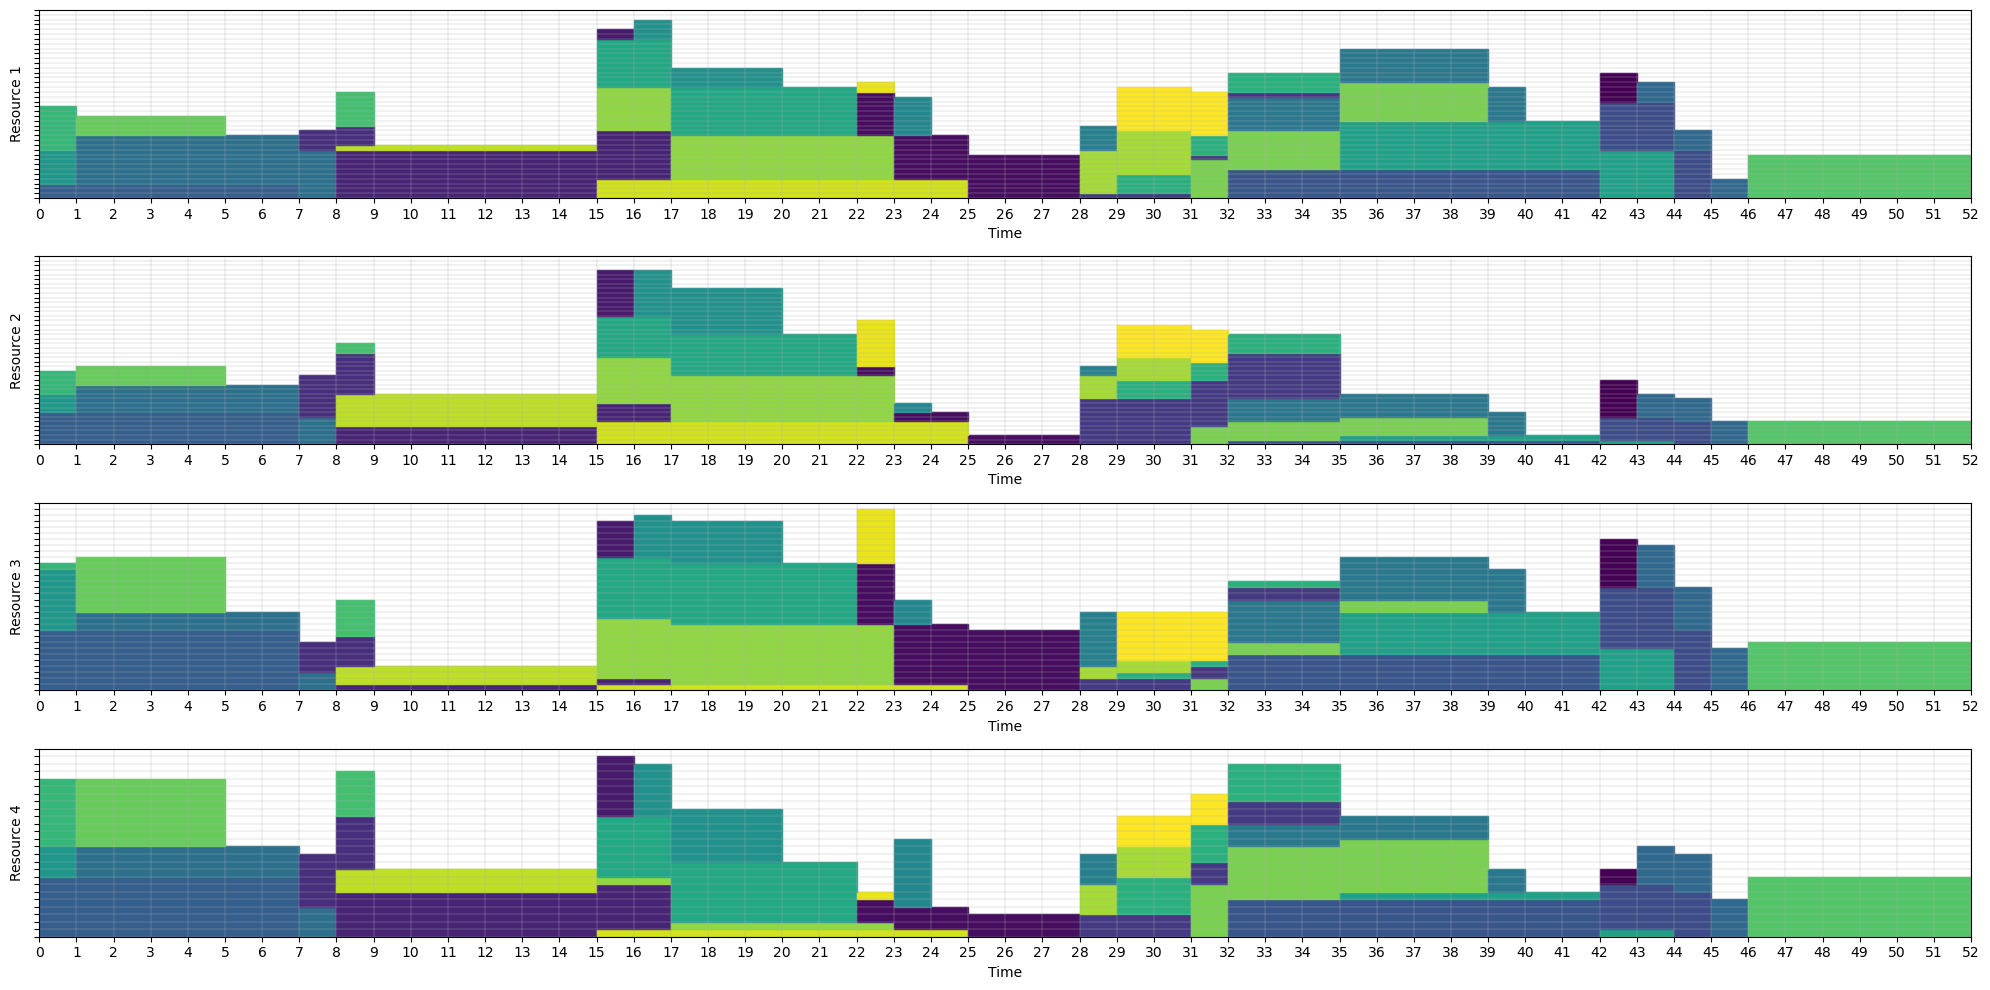

In [ ]:
for event in solution.events:
    print(f"Event {event.id} at time {event.startTime}, jobs: {', '.join(str(job.id + 1) for job in event.jobs)}")
plot_solution(solution)

In [252]:
solutions = [psmodel.generate_random_solution() for i in range(1000000)]

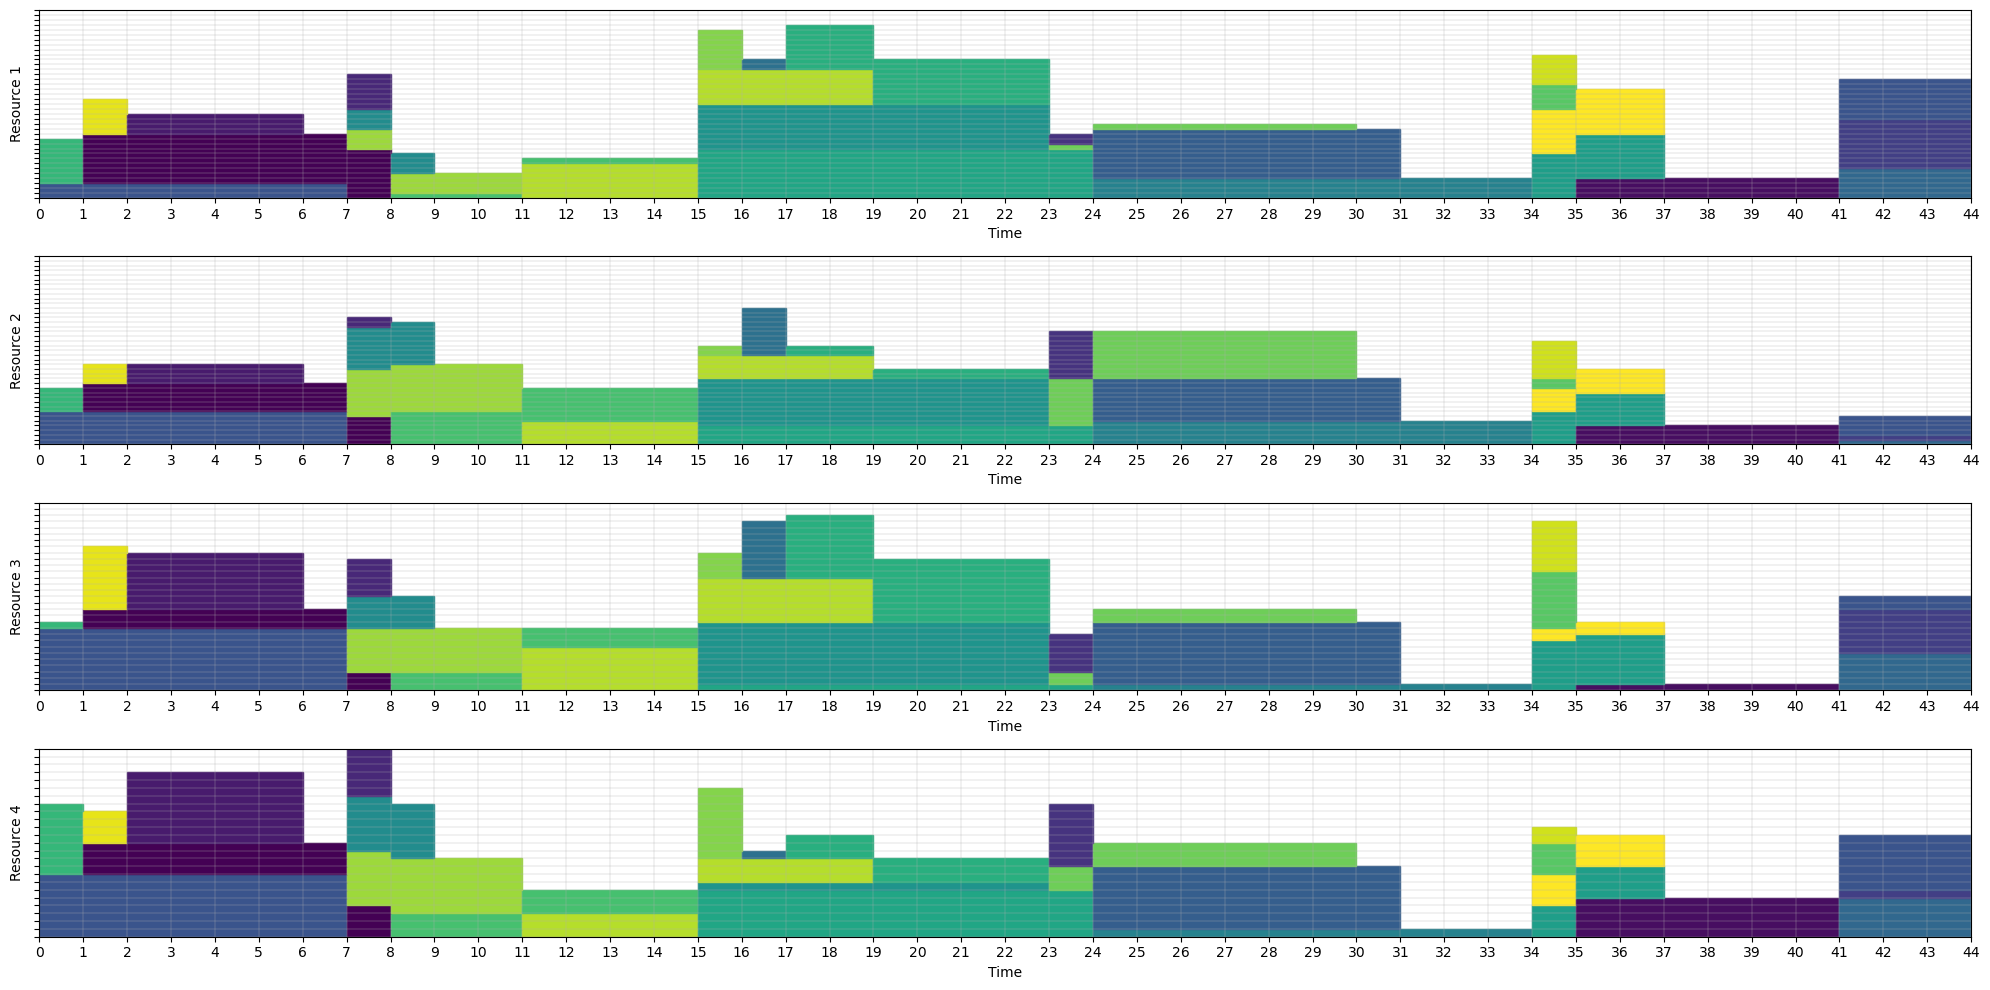

In [253]:
best = min(solutions, key=lambda x: x.events[-1].startTime)
plot_solution(best)